In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from model_distances import distance_matrix
from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Hyperparameters

In [4]:
RERUN = False

In [5]:
EXPERIMENT_PATH = Path.cwd() / 'results' / 'hr_analysis_cifar10'

if not EXPERIMENT_PATH.is_dir():
    os.makedirs(EXPERIMENT_PATH)

In [6]:
# Test set corresponding to the data used to train the model zoo
TESTSET_DS = torch.load('/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt')['testset']
TESTSET_DL = torch.utils.data.DataLoader(TESTSET_DS, batch_size=64, shuffle=False)

# Model zoo
ZOO_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/cifar10_train_zoo_relu')
ZOO_DS = torch.load(ZOO_PATH / 'dataset_test.pt')
ZOO_DL = torch.utils.data.DataLoader(ZOO_DS, batch_size=16, shuffle=False)

ZOO_DS_TRAIN = torch.load(ZOO_PATH / 'dataset_train.pt')
ZOO_DL_TRAIN = torch.utils.data.DataLoader(ZOO_DS_TRAIN, batch_size=16, shuffle=False)

# Threshold used to define models that "perform well"; depends on the zoo
MODEL_ACC_THR = 0.6

# Path to the hyper-representation models
HYPERREP_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune/cifar10_train_hyperrep')

## Loading data

### Loading HR models meta-data

In [7]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for path in os.listdir(HYPERREP_PATH):
    if not re.match('AE_trainable', path):
        continue
    path = HYPERREP_PATH / path
    
    with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
        config = json.load(ifh_config)
        result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})
    
    for edx in range(len(result)):
        df_hr.loc[len(df_hr)] = (
            result.loc[edx]['trial_id'],
            config['optim::lr'],
            config['ae:lat_dim'],
            config['training::loss_distillation'],
            config['training::queryset_distillation'],
            config['training::queryset_dump'],
            config['training::n_queries_distillation'],
            config['training::gamma'],
            config['training::beta'],
            result.loc[edx]['training_iteration'],
            result.loc[edx]['loss/loss_train'],
            result.loc[edx]['loss/loss_contrast_train'],
            result.loc[edx]['loss/loss_recon_train'],
            result.loc[edx]['loss/loss_structure_train'],
            result.loc[edx]['loss/loss_behaviour_train'],
            result.loc[edx]['loss/loss_test'],
            result.loc[edx]['loss/loss_contrast_test'],
            result.loc[edx]['loss/loss_recon_test'],
            result.loc[edx]['loss/loss_structure_test'],
            result.loc[edx]['loss/loss_behaviour_test'],
            result.loc[edx]['dstk/test_acc_test'],
            result.loc[edx]['dstk/ggap_test']
        )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet-32'
})
df_hr.head()

,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,Epoch,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,0d5ff_00019,0.0001,64,cross_entropy,data,CIFAR-10,256,0.05,0.0,0,...,0.934982,0.0,0.934982,1.463741,1.032117,1.486458,0.0,1.486458,0.768336,0.58211
1,0d5ff_00019,0.0001,64,cross_entropy,data,CIFAR-10,256,0.05,0.0,1,...,0.292866,0.0,0.292866,NaN,NaN,0.380237,0.0,0.380237,NaN,NaN
2,0d5ff_00019,0.0001,64,cross_entropy,data,CIFAR-10,256,0.05,0.0,2,...,0.289190,0.0,0.289190,NaN,NaN,0.367300,0.0,0.367300,NaN,NaN
3,0d5ff_00019,0.0001,64,cross_entropy,data,CIFAR-10,256,0.05,0.0,3,...,0.293232,0.0,0.293232,NaN,NaN,0.359415,0.0,0.359415,NaN,NaN
4,0d5ff_00019,0.0001,64,cross_entropy,data,CIFAR-10,256,0.05,0.0,4,...,0.288773,0.0,0.288773,NaN,NaN,0.376265,0.0,0.376265,NaN,NaN


### Loading checkpoints

In [8]:
# Loading hyper-reps
def load_hr(trial_id):
    for path in os.listdir(HYPERREP_PATH):
        if trial_id in path:
            model_path = HYPERREP_PATH / path
    return load_hyperrep_edx(model_path, MAX_EPOCH)

hyper_reps = {idx: load_hr(idx) for idx in df_hr['Trial ID'].unique()}

In [9]:
# Loading reference config
trial_id = df_hr.iloc[0]['Trial ID']
for path in os.listdir(HYPERREP_PATH):
    if trial_id in path:
        model_path = HYPERREP_PATH / path
        with open(HYPERREP_PATH / path / 'params.json') as ifh:
            ref_config = json.load(ifh)

# Loading reference params
ref_path = ref_config["training::distil_reference"]
with open(os.path.join(ref_path, 'params.json')) as ifh:
    reference_params = json.load(ifh)
    
# Loading reference checkpoint
ref_chkpth = None
for chkpth in os.listdir(ref_path):
    if 'checkpoint_' in chkpth:
        if not ref_chkpth or int(chkpth.split('_')[-1]) > int(ref_chkpth.split('_')[-1]):
            ref_chkpth = chkpth

reference_checkpoint = torch.load(Path(ref_path) / str(ref_chkpth) / 'checkpoints', map_location=torch.device("cpu"))
reference_checkpoint_cuda = {k: v.to('cuda') for k, v in deepcopy(reference_checkpoint).items()}

## Analysing the training loss

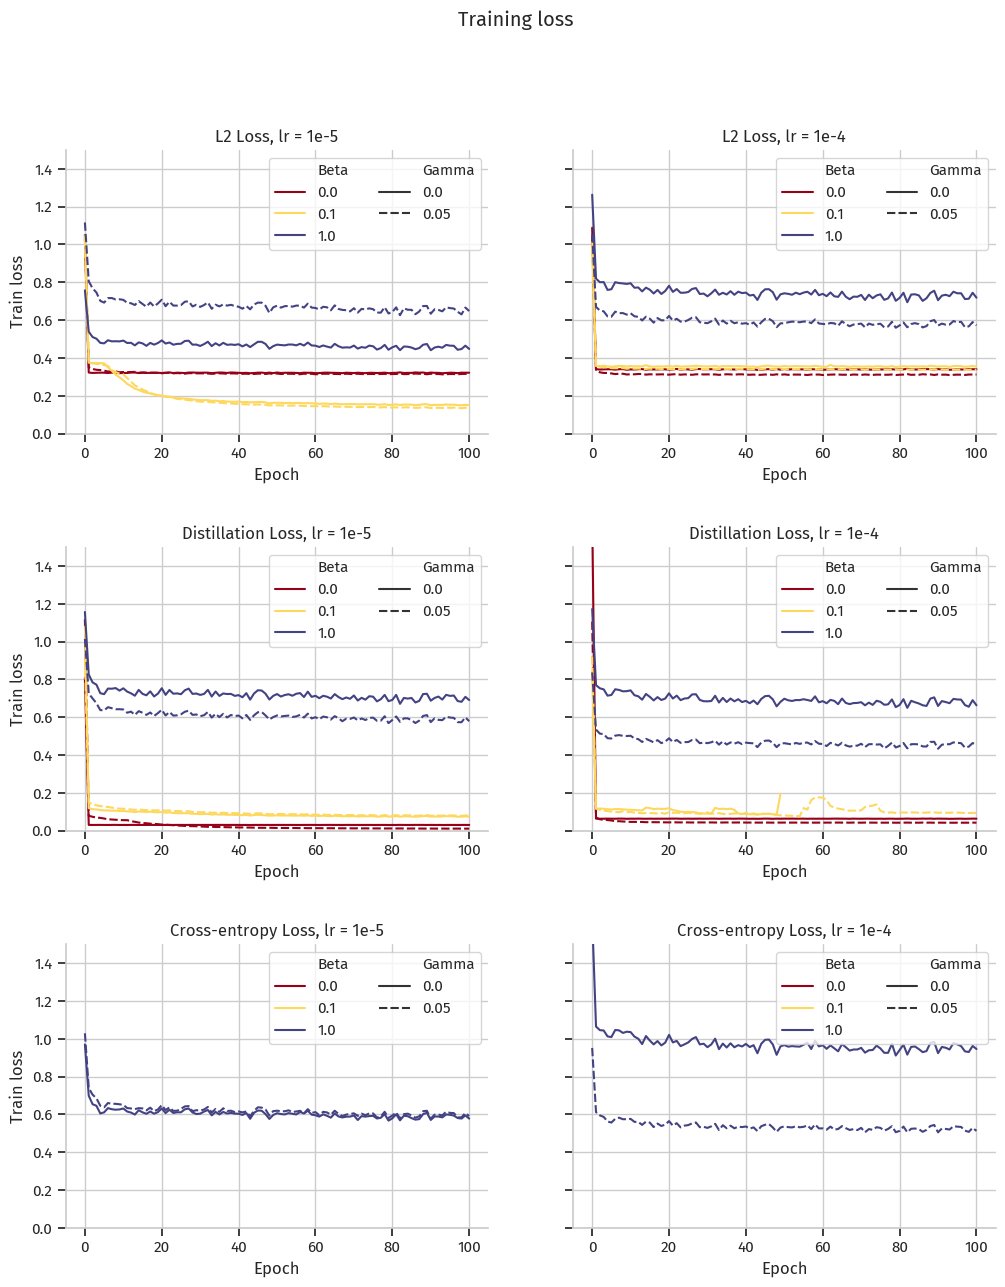

In [ ]:
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(12, 14))

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'l2') & (df_hr['Learning rate'] == 1e-5)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[0][0]).set(
    title='L2 Loss, lr = 1e-5'
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'l2') & (df_hr['Learning rate'] == 1e-4)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[0][1]).set(
    title='L2 Loss, lr = 1e-4', ylim=(0., 1.5)
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'distillation') & (df_hr['Learning rate'] == 1e-5)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[1][0]).set(
    title='Distillation Loss, lr = 1e-5'
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'distillation') & (df_hr['Learning rate'] == 1e-4)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[1][1]).set(
    title='Distillation Loss, lr = 1e-4', ylim=(0., 1.5)
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'cross_entropy') & (df_hr['Learning rate'] == 1e-5)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[2][0]).set(
    title='Cross-entropy Loss, lr = 1e-5'
)

sns.lineplot(df_hr[(df_hr['Behaviour loss'] == 'cross_entropy') & (df_hr['Learning rate'] == 1e-4)], x='Epoch', y='Train loss', hue='Beta', style='Gamma', palette=COLOURS[:3], ax=axs[2][1]).set(
    title='Cross-entropy Loss, lr = 1e-4', ylim=(0., 1.5)
)

for ax in axs.flatten():
    ax.legend(ncol=2)

plt.suptitle('Training loss')
plt.subplots_adjust(hspace=0.40)
plt.show()

### Extracting key models

In [11]:
df_hr[(df_hr['Epoch'] == MAX_EPOCH) & (df_hr['Behaviour loss'] == 'l2')]

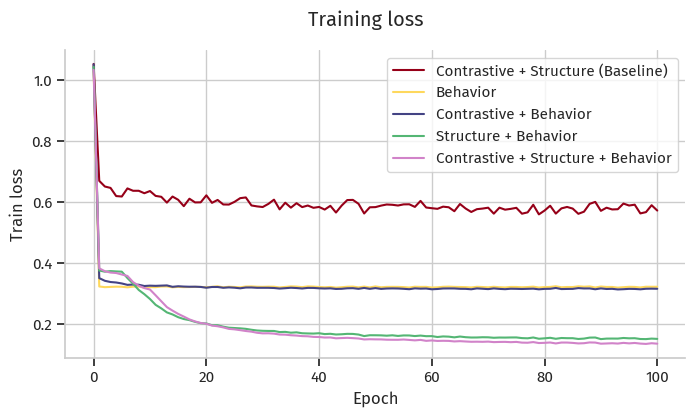

In [12]:
idx_dict = {
    '0d5ff_00011': 'Contrastive + Structure (Baseline)',
    '0d5ff_00000': 'Behavior',
    '0d5ff_00006': 'Contrastive + Behavior',
    '0d5ff_00002': 'Structure + Behavior',
    '0d5ff_00008': 'Contrastive + Structure + Behavior'
}
idx_ref_chk = list(idx_dict.keys())[0]
f"Reference checkpoint: {idx_ref_chk}"


_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Train loss', color=COLOURS[i], label=label, ax=ax)
    
plt.legend()
plt.suptitle('Training loss')
plt.show()

## Analysing discriminative downstream tasks

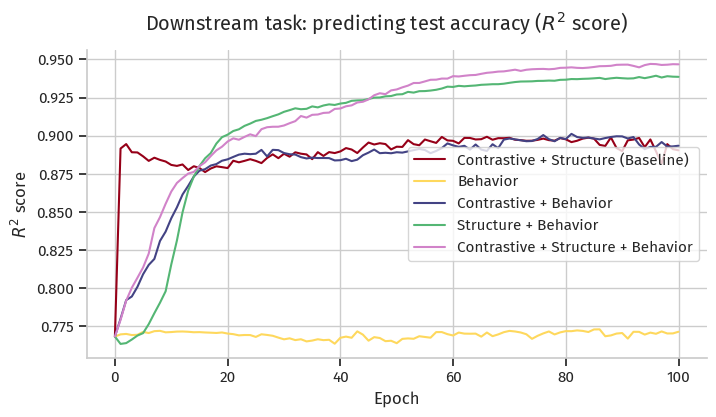

In [13]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: Test accuracy', color=COLOURS[i], label=label, ax=ax)
    
ax.set(ylabel='$R^2$ score')
    
plt.legend()
plt.suptitle('Downstream task: predicting test accuracy ($R^2$ score)')
plt.show()

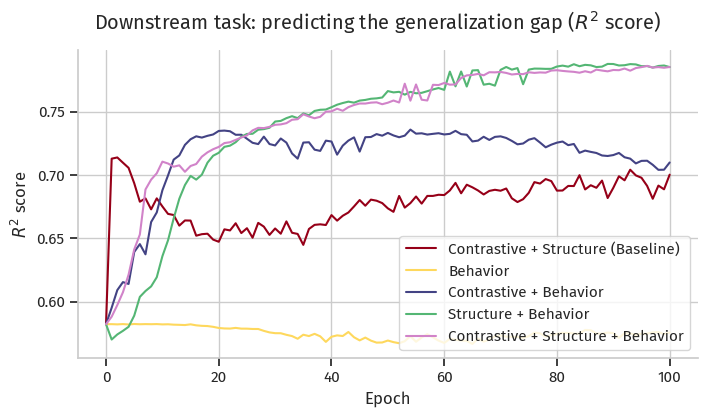

In [14]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: GGap', color=COLOURS[i], label=label, ax=ax)
    
ax.set(ylabel='$R^2$ score')
    
plt.legend()
plt.suptitle('Downstream task: predicting the generalization gap ($R^2$ score)')
plt.show()

## Analysing reconstruction

In [15]:
def compute_reconstruction_acc(hr, x, p, i, dataloader):
    z, y, zp = hr.forward(x, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return test_model(model, dataloader, device='cuda')

### Distribution of reconstructed accuracies

In [16]:
DF_ZOO_ACC_PATH = EXPERIMENT_PATH / 'df_zoo_acc.csv'
DF_Z_PATH = EXPERIMENT_PATH / 'df_z_dict.csv'
DF_X_PATH = EXPERIMENT_PATH / 'df_x_dict.csv'

X_DIM_1, X_DIM_2 = next(iter(ZOO_DL))[0].shape[1:3]
X_COLS = [f'Dimension {i}' for i in range(X_DIM_1 * X_DIM_2)]

Z_DIM_1 = X_DIM_1
Z_DIM_2 = 64
Z_COLS = [f'Dimension {i}' for i in range(Z_DIM_1 * Z_DIM_2)]

if not DF_ZOO_ACC_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_acc = pd.DataFrame(columns=['Model index', 'Hyper-representation model', 'Original accuracy', 'Reconstruction accuracy'])
    df_x = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + X_COLS)
    df_z = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + Z_COLS)

    # Run experiments
    for bdx, data in enumerate(tqdm(ZOO_DL)):
        x, m, p, _ = data

        for hr_idx, hr_label in idx_dict.items():
            z, y, _ = hyper_reps[hr_idx].forward(x, p)
            
            for idx in range(x.shape[0]):
                # Original accuracy
                orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
                orig_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                orig_model.load_state_dict(orig_checkpoint)
                orig_acc = test_model(orig_model, TESTSET_DL)
                
                # Reconstruction accuracy
                recon_checkpoint = tokens_to_checkpoint(y[idx], p[idx], reference_checkpoint)
                recon_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                recon_model.load_state_dict(recon_checkpoint)
                recon_acc = test_model(recon_model, TESTSET_DL)
                
                # Save results to DataFrame
                mdx = bdx * x.shape[0] + idx
                df_zoo_acc.loc[len(df_zoo_acc)] = (
                    mdx,
                    hr_label,
                    orig_acc,
                    recon_acc
                )
                df_x.loc[len(df_x)] = [mdx, hr_label] + x[idx].flatten().tolist()
                df_z.loc[len(df_z)] = [mdx, hr_label] + z[idx].flatten().tolist()

    # Save results to disk
    df_zoo_acc.to_csv(DF_ZOO_ACC_PATH)
    df_x.to_csv(DF_X_PATH)
    df_z.to_csv(DF_Z_PATH)
    
df_zoo_acc = pd.read_csv(DF_ZOO_ACC_PATH, index_col=0)
df_x = pd.read_csv(DF_X_PATH, index_col=0)
df_z = pd.read_csv(DF_Z_PATH, index_col=0)
df_zoo_acc.head()

,Model index,Hyper-representation model,Original accuracy,Reconstruction accuracy
0,0,Contrastive + Structure (Baseline),0.1000,0.1001
1,1,Contrastive + Structure (Baseline),0.4288,0.1870
2,2,Contrastive + Structure (Baseline),0.5539,0.2494
3,3,Contrastive + Structure (Baseline),0.6011,0.2562
4,4,Contrastive + Structure (Baseline),0.6644,0.4045


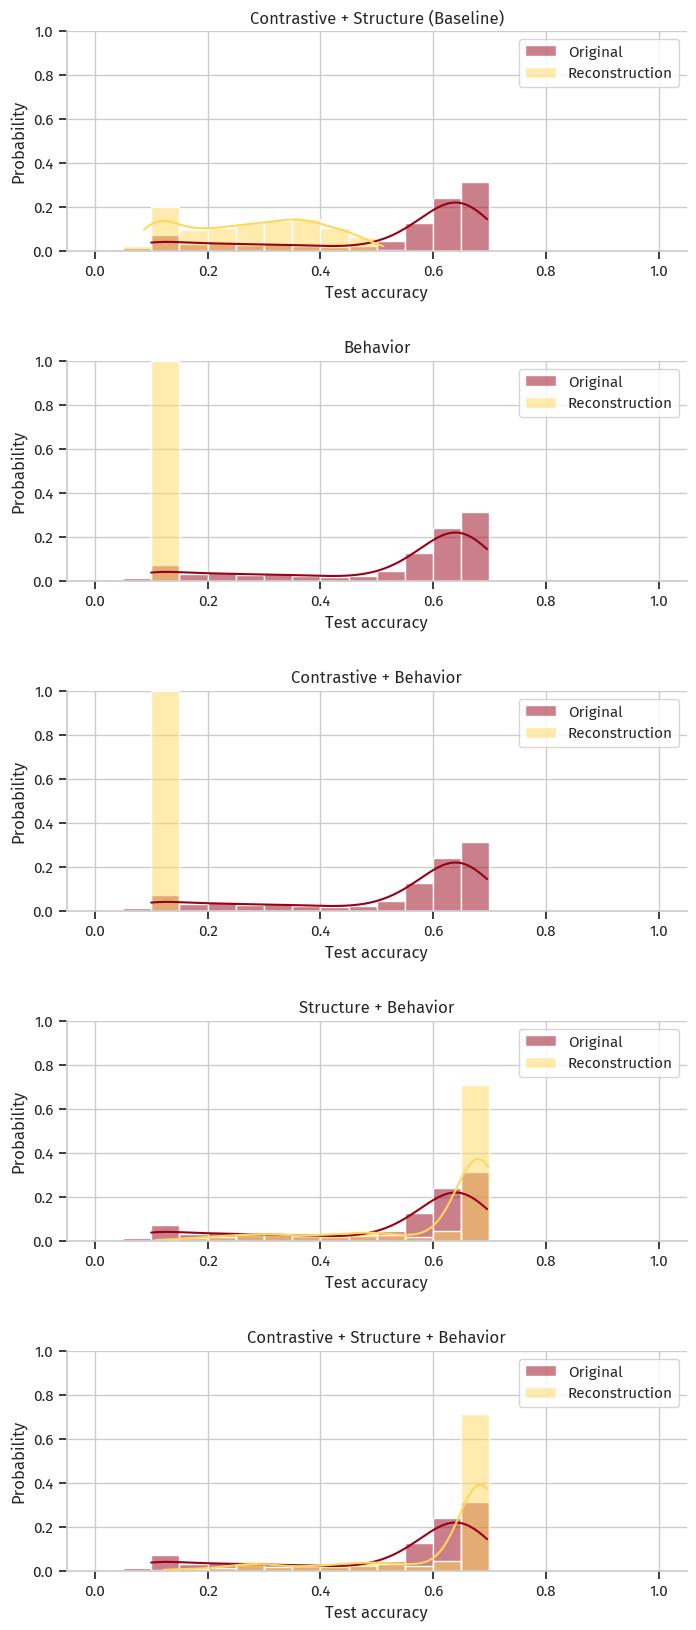

In [17]:
_, axs = plt.subplots(len(idx_dict), 1, figsize=(8, 4*len(idx_dict)))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i])
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i])
    axs[i].set(title=label, xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    axs[i].legend()
    
plt.subplots_adjust(hspace=0.5)
plt.show()

### Pairwise $L^2$ distance between weights

In [18]:
DF_ZOO_L2WEIGHTS_PATH = EXPERIMENT_PATH / 'df_zoo_l2weights.csv'

if not DF_ZOO_L2WEIGHTS_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_l2weights = pd.DataFrame(columns=['Hyper-representation model', 'L2 (structure)', 'MSE (structure)'])

    # Run experiments
    for data in tqdm(ZOO_DL):
        x, m, p, _ = data

        for hr_idx, hr_label in idx_dict.items():
            _, y, _ = hyper_reps[hr_idx].forward(x, p)
            
            for j in range(x.shape[0]):
                df_zoo_l2weights.loc[len(df_zoo_l2weights)] = (
                    hr_label,
                    torch.sqrt(torch.sum((x[j] - y[j]) ** 2)).item(),
                    torch.mean((x[j] - y[j]) ** 2).item()
                )
                
    # Save results
    df_zoo_l2weights.to_csv(DF_ZOO_L2WEIGHTS_PATH)
    
df_zoo_l2weights = pd.read_csv(DF_ZOO_L2WEIGHTS_PATH, index_col=0)
df_zoo_l2weights.head()

,Hyper-representation model,L2 (structure),MSE (structure)
0,Contrastive + Structure (Baseline),62.479706,0.145244
1,Contrastive + Structure (Baseline),44.030872,0.072133
2,Contrastive + Structure (Baseline),42.944336,0.068617
3,Contrastive + Structure (Baseline),42.365330,0.066779
4,Contrastive + Structure (Baseline),24.703394,0.022706


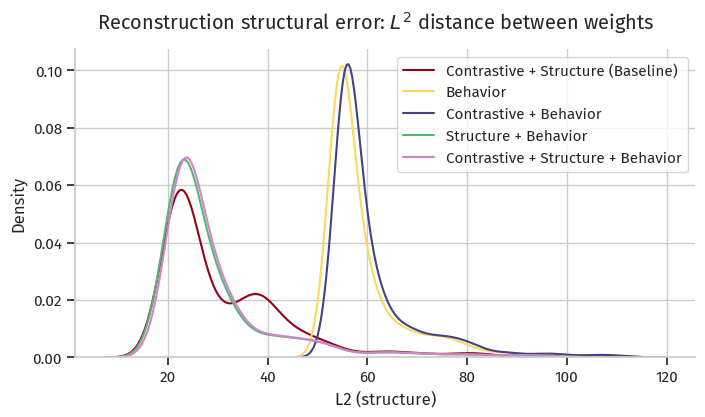

In [19]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.kdeplot(df_zoo_l2weights[df_zoo_l2weights['Hyper-representation model'] == label], x='L2 (structure)', color=COLOURS[i], label=label, ax=ax)
    
plt.legend()
plt.suptitle('Reconstruction structural error: $L^2$ distance between weights')
plt.show()

### Pairwise $L^2$ distance between predictions

In [20]:
def reconstruct_model(hr, x, p, i):
    z, y, zp = hr.forward(x, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

In [21]:
DF_ZOO_L2PREDS_PATH = EXPERIMENT_PATH / 'df_zoo_l2preds.csv'

if not DF_ZOO_L2PREDS_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_l2preds = pd.DataFrame(columns=['Hyper-representation model', 'L2 (behavior)', 'MSE (behavior)', 'Agreement'])

    # Run experiments
    for data in tqdm(ZOO_DL):
        x, m, p, _ = data

        for i in range(x.shape[0]):
            checkpoint = tokens_to_checkpoint(x[i], p[i], reference_checkpoint)
            orig_model = CNN3(
                channels_in=reference_params['model::channels_in'],
                nlin=reference_params['model::nlin'],
                dropout=reference_params['model::dropout']
            )
            orig_model.load_state_dict(checkpoint)

            for hr_idx, hr_label in idx_dict.items():   
                recon_model = reconstruct_model(hyper_reps[hr_idx], x, p, i)
                
                l2_dist, mse, agreement = compare_models_prediction(orig_model, recon_model, TESTSET_DL, n_batches=None)
                
                df_zoo_l2preds.loc[len(df_zoo_l2preds)] = (
                    hr_label,
                    l2_dist,
                    mse,
                    agreement
                )
                    
                
    # Save results
    df_zoo_l2preds.to_csv(DF_ZOO_L2PREDS_PATH)
    
df_zoo_l2preds = pd.read_csv(DF_ZOO_L2PREDS_PATH, index_col=0)
df_zoo_l2preds.head()

,Hyper-representation model,L2 (behavior),MSE (behavior),Agreement
0,Contrastive + Structure (Baseline),0.016329,0.000218,0.0018
1,Behavior,0.011628,0.000014,0.0000
2,Contrastive + Behavior,0.006727,0.000005,0.0000
3,Structure + Behavior,0.052978,0.000341,0.2708
4,Contrastive + Structure + Behavior,0.096734,0.001276,0.0161


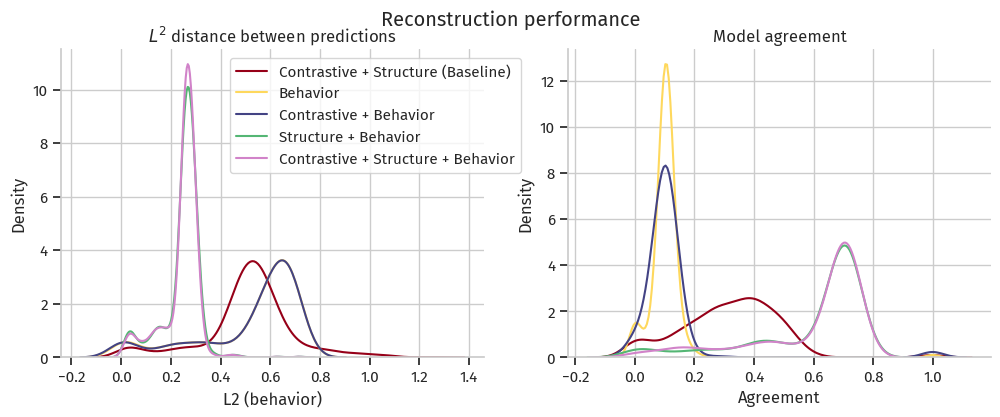

In [22]:
_, axs = plt.subplots(1 ,2, figsize=(12, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.kdeplot(df_zoo_l2preds[df_zoo_l2preds['Hyper-representation model'] == label], x='L2 (behavior)', color=COLOURS[i], label=label, ax=axs[0])
    sns.kdeplot(df_zoo_l2preds[df_zoo_l2preds['Hyper-representation model'] == label], x='Agreement', color=COLOURS[i], label=label, ax=axs[1])
    
    
axs[0].set(title='$L^2$ distance between predictions')
axs[1].set(title='Model agreement')
    
plt.legend(loc=(-0.80, 0.60))
plt.suptitle('Reconstruction performance')
plt.show()

## Analysing generative downstream tasks

In [23]:
def compute_acc_from_z(hr, z, p, i, dataloader):
    z = z.type(next(hr.parameters()).dtype)

    y = hr.to(z.device).forward_decoder(z, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint_cuda)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return test_model(model, dataloader)

In [24]:
# Select only models with original accuracy above a threshold
good_models_ids = df_zoo_acc[df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR]['Model index'].unique().tolist()
df_z_good_models = df_z[df_z['Model index'].isin(good_models_ids)]

# Generate anchors and samples
z_anchors = {hr_label: df_z_good_models[df_z_good_models['Hyper-representation model'] == hr_label][Z_COLS].values for hr_label in idx_dict.values()}
z_samples = {k: generate_z_samples(z) for k, z in z_anchors.items()}

# Print diagnostic statistics:
df_diagnostic = pd.DataFrame(columns=['Original std', 'Sampled std'])
for key in z_anchors.keys():
    df_diagnostic.loc[key] = (
        z_anchors[key].std(axis=0).mean(),
        z_samples[key].std(axis=0).mean()
    )
display(df_diagnostic)

# Reshape anchors and samples
z_anchors = {k: z.reshape((-1, Z_DIM_1, Z_DIM_2)) for k, z in z_anchors.items()}
z_samples = {k: z.reshape((-1, Z_DIM_1, Z_DIM_2)) for k, z in z_samples.items()}

del df_z_good_models, df_diagnostic

,Original std,Sampled std
Contrastive + Structure (Baseline),0.361463,0.279925
Behavior,0.218247,0.166631
Contrastive + Behavior,0.103190,0.085936
Structure + Behavior,0.066189,0.052503
Contrastive + Structure + Behavior,0.060213,0.049578


In [25]:
DF_GENERATIVE_PATH = EXPERIMENT_PATH / 'df_generative.csv'

if not DF_GENERATIVE_PATH.is_file() or RERUN:
    # Create dataframe
    df_generative = pd.DataFrame(columns=['Hyper-representation model', 'Origin', 'Accuracy'])
    
    p = next(iter(ZOO_DL))[2]

    for hr_idx, hr_label in tqdm(idx_dict.items(), unit='hyperrepresentation model'):
        z = torch.tensor(z_samples[hr_label]).to('cuda')
        p_z = p[0].repeat(z.shape[0], 1, 1).to('cuda') 
        
        for i in range(z.shape[0]):
            recon_acc = compute_acc_from_z(hyper_reps[hr_idx], z, p_z, i, TESTSET_DL)
            df_generative.loc[len(df_generative)] = (
                hr_label,
                'Generated',
                recon_acc
            )
                
    # Save results
    df_generative.to_csv(DF_GENERATIVE_PATH)
    
df_generative = pd.read_csv(DF_GENERATIVE_PATH, index_col=0)
df_generative.head()

,Hyper-representation model,Origin,Accuracy
0,Contrastive + Structure (Baseline),Generated,0.2607
1,Contrastive + Structure (Baseline),Generated,0.2884
2,Contrastive + Structure (Baseline),Generated,0.3189
3,Contrastive + Structure (Baseline),Generated,0.1000
4,Contrastive + Structure (Baseline),Generated,0.2391


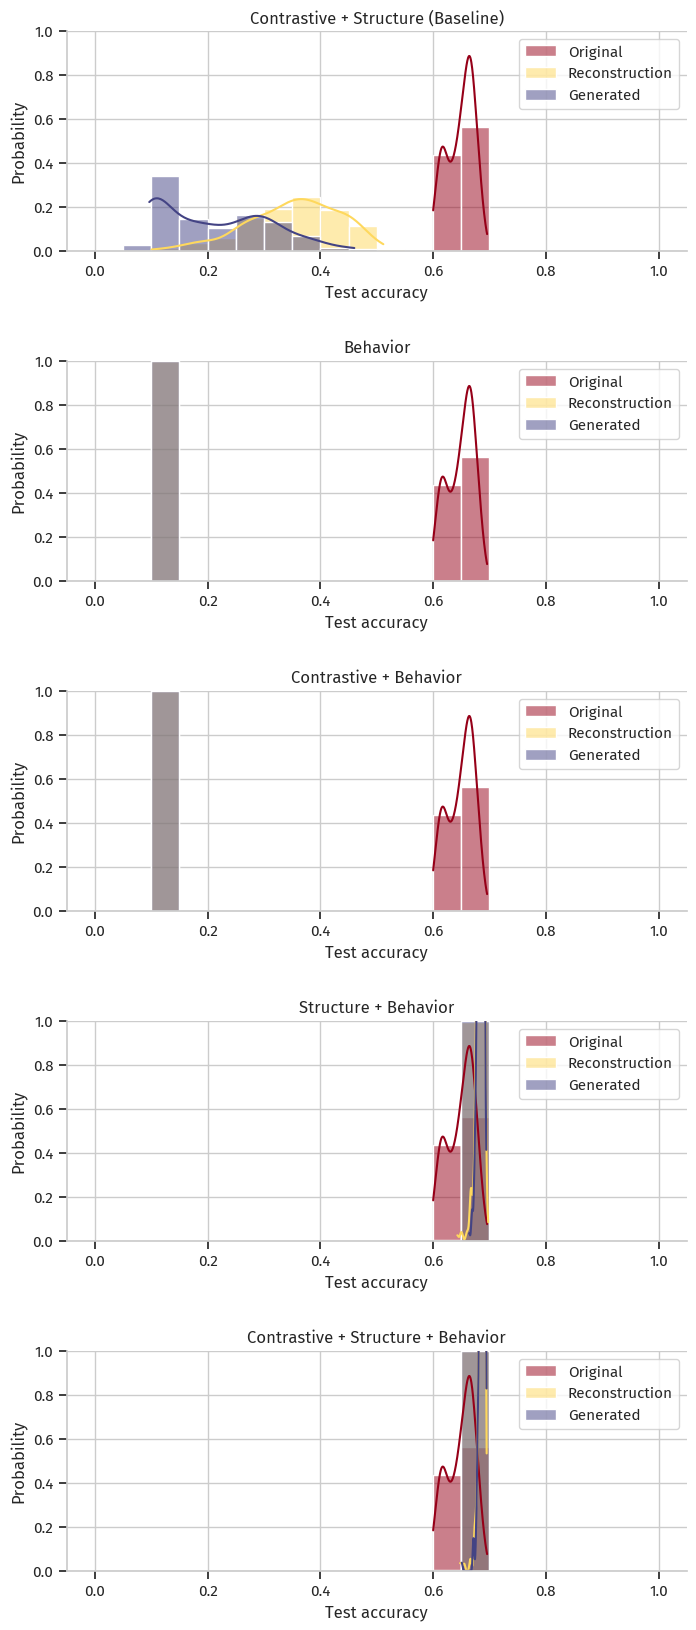

In [26]:
n_figures = len(df_generative['Hyper-representation model'].unique())

fig, axs = plt.subplots(n_figures, figsize=(8, 4*n_figures))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.histplot(df_zoo_acc[(df_zoo_acc['Hyper-representation model'] == label) & (df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR)], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i])
    sns.histplot(df_zoo_acc[(df_zoo_acc['Hyper-representation model'] == label) & (df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR)], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i])
    sns.histplot(
        df_generative[(df_generative['Hyper-representation model'] == label) & (df_generative['Origin'] == 'Generated')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[2],
        alpha=0.5,
        label='Generated',
        ax=axs[i]
    )
    axs[i].set(title=label, xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    axs[i].legend()
    
plt.subplots_adjust(hspace=0.5)
plt.show()

### Verifying model diversity

In [27]:
def x_to_checkpoint(x, p, i):
    checkpoint = tokens_to_checkpoint(x[i], p[i], reference_checkpoint_cuda)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

def z_to_checkpoint(hr, z, p, i):
    z = z.type(next(hr.parameters()).dtype)

    y = hr.to(z.device).forward_decoder(z, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint_cuda)
    model = CNN3(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

In [28]:
GEN_DIVERSITY_PATH = EXPERIMENT_PATH / 'gen_diversity.json'

if not GEN_DIVERSITY_PATH.is_file() or RERUN:
    gen_diversity = dict()
    
    p = next(iter(ZOO_DL))[2]
    
    # Original model zoo
    df_x_good_models = df_x[df_x['Model index'].isin(good_models_ids)]
    x = df_x_good_models[df_x_good_models['Hyper-representation model'] == list(idx_dict.values())[0]][X_COLS].values.reshape((-1, X_DIM_1, X_DIM_2))
    x = torch.tensor(x).to('cuda')
    p_x = p[0].repeat(x.shape[0], 1, 1).to('cuda')
    original_models = [x_to_checkpoint(x, p_x, i) for i in range(x.shape[0])]
    gen_diversity['Model zoo'] = dict()
    
    # L2 (weights)
    dist_mat = distance_matrix(original_models, metric='l2')
    distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
    gen_diversity['Model zoo']['l2_structure'] = distances.tolist()
    
    # L2 (predictions)
    dist_mat = distance_matrix(original_models, metric='l2_preds', testset='data', ds_test=TESTSET_DS)
    distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
    gen_diversity['Model zoo']['l2_behaviour'] = distances.tolist()
    
    del df_x_good_models, x, original_models

    for hr_idx, hr_label in tqdm(idx_dict.items(), unit='hyperrepresentation model'):        
        z = torch.tensor(z_samples[hr_label]).to('cuda')
        p_z = p[0].repeat(z.shape[0], 1, 1).to('cuda')
        generated_models = [z_to_checkpoint(hyper_reps[hr_idx], z, p_z, i) for i in range(z.shape[0])]
        gen_diversity[hr_label] = dict()
    
        # L2 (weights)
        dist_mat = distance_matrix(generated_models, metric='l2')
        distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
        gen_diversity[hr_label]['l2_structure'] = distances.tolist()

        # L2 (predictions)
        dist_mat = distance_matrix(generated_models, metric='l2_preds', testset='data', ds_test=TESTSET_DS)
        distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
        gen_diversity[hr_label]['l2_behaviour'] = distances.tolist()
        
        del z, generated_models
                
    # Save results
    with open(GEN_DIVERSITY_PATH, 'w') as ofh:
        json.dump(gen_diversity, ofh)
    
with open(GEN_DIVERSITY_PATH, 'r') as ifh:
    gen_diversity = json.load(ifh)

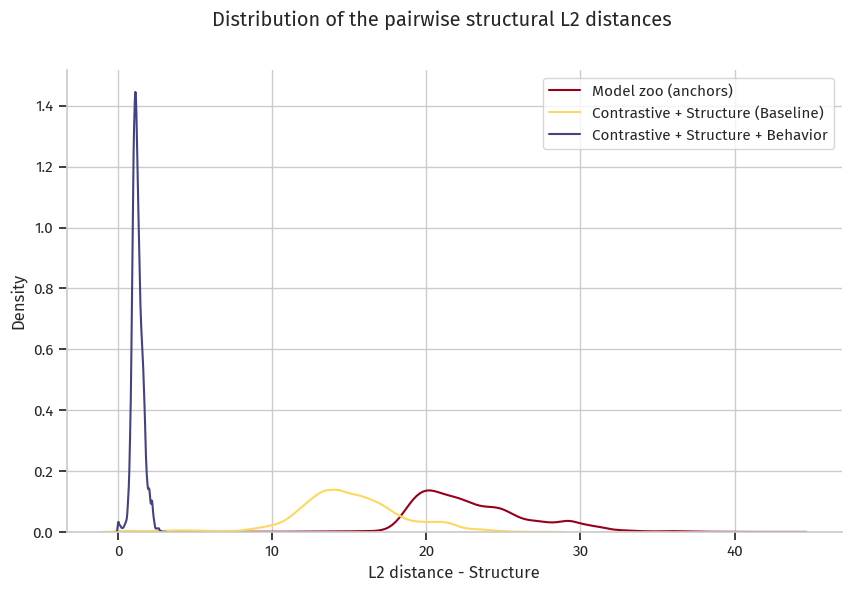

In [29]:
_, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(gen_diversity['Model zoo']['l2_structure'], color=COLOURS[0], label='Model zoo (anchors)', ax=ax)
sns.kdeplot(gen_diversity['Contrastive + Structure (Baseline)']['l2_structure'], color=COLOURS[1], label='Contrastive + Structure (Baseline)', ax=ax)
sns.kdeplot(gen_diversity['Contrastive + Structure + Behavior']['l2_structure'], color=COLOURS[2], label='Contrastive + Structure + Behavior', ax=ax)

ax.set(xlabel='L2 distance - Structure')

plt.legend()
plt.suptitle('Distribution of the pairwise structural L2 distances')
plt.show()

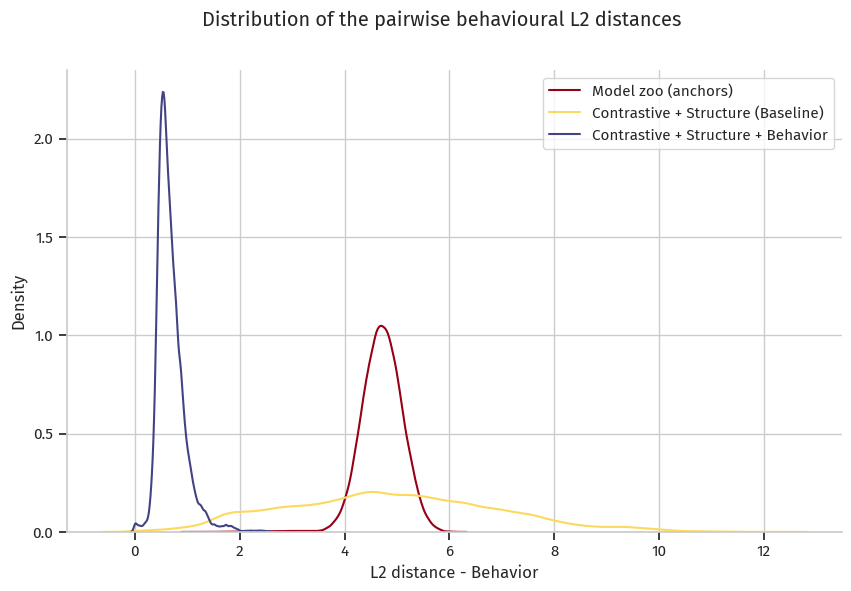

In [30]:
_, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(gen_diversity['Model zoo']['l2_behaviour'], color=COLOURS[0], label='Model zoo (anchors)', ax=ax)
sns.kdeplot(gen_diversity['Contrastive + Structure (Baseline)']['l2_behaviour'], color=COLOURS[1], label='Contrastive + Structure (Baseline)', ax=ax)
sns.kdeplot(gen_diversity['Contrastive + Structure + Behavior']['l2_behaviour'], color=COLOURS[2], label='Contrastive + Structure + Behavior', ax=ax)

ax.set(xlabel='L2 distance - Behavior')

plt.legend()
plt.suptitle('Distribution of the pairwise behavioural L2 distances')
plt.show()

## Eigenspectrum analysis

In [31]:
def model_to_vector(model):
    # Get the state dictionary of the model
    state_dict = model.state_dict()
    # Flatten the state dictionary into a one-dimensional vector
    vector = np.concatenate([param.data.detach().cpu().numpy().flatten() for param in state_dict.values()])
    return vector

In [32]:
from sklearn.preprocessing import StandardScaler

MODELS_PATH = EXPERIMENT_PATH / 'models.npz'
COVMAT_PATH = EXPERIMENT_PATH / 'covmat.npz'
EIGVAL_PATH = EXPERIMENT_PATH / 'eigval.npz'
EIGVEC_PATH = EXPERIMENT_PATH / 'eigvec.npz'

if not COVMAT_PATH.is_file() or True:
    # Create dataframe
    df_zoo_eig = pd.DataFrame(columns=['Model index', 'Hyper-representation model', 'Original accuracy', 'Reconstruction accuracy'])
    
    models = dict()
    models['Zoo'] = []

    # Run experiments
    for bdx, data in enumerate(tqdm(ZOO_DL, desc="Computing reconstructions")):
        x, m, p, _ = data
        
        for idx in range(x.shape[0]):
            # Original accuracy
            orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
            orig_model = CNN3(
                channels_in=reference_params['model::channels_in'],
                nlin=reference_params['model::nlin'],
                dropout=reference_params['model::dropout']
            )
            orig_model.load_state_dict(orig_checkpoint)
            models['Zoo'].append(model_to_vector(orig_model))

        for hr_idx, hr_label in idx_dict.items():
            z, y, _ = hyper_reps[hr_idx].forward(x, p)
            
            if hr_label not in models:
                models[hr_label] = []
            
            for idx in range(y.shape[0]):
                # Reconstruction accuracy
                recon_checkpoint = tokens_to_checkpoint(y[idx], p[idx], reference_checkpoint)
                recon_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                recon_model.load_state_dict(recon_checkpoint)
                models[hr_label].append(model_to_vector(recon_model))

    models = {k: np.vstack(X) for k, X in models.items()}
    
    # Step 1: Center and scale the data using StandardScaler
    # models = {k: StandardScaler().fit_transform(X) for k, X in models.items()}
    
    # Step 2: Compute the covariance matrix
    print("Computing covariance matrices...")
    covmat = {k: np.cov(X, rowvar=False) for k, X in models.items()}
    
    # Step 3: Compute eigenvalues and eigenvectors
    eigenvalues = dict()
    eigenvectors = dict()
    
    for k, X_cov in tqdm(covmat.items(), total=len(covmat), desc="Computing eigendecompositions"):
        eigval, eigvec = np.linalg.eigh(X_cov)
        sorted_indices = np.argsort(eigval)[::-1] # Sorted by descending order
        eigenvalues[k] = eigval[sorted_indices]
        eigenvectors[k] = eigvec[:, sorted_indices]
    
    # Save results to disk
    print("Saving to disk...")
    np.savez(MODELS_PATH, **models)
    np.savez(COVMAT_PATH, **covmat)
    np.savez(EIGVAL_PATH, **eigenvalues)
    np.savez(EIGVEC_PATH, **eigenvectors)
    
print("Loading from disk...")    
models = np.load(MODELS_PATH)
models = {k: models[k] for k in models.files}
    
covmat = np.load(COVMAT_PATH)
covmat = {k: covmat[k] for k in covmat.files}

eigenvalues = np.load(EIGVAL_PATH)
eigenvalues = {k: eigenvalues[k] for k in eigenvalues.files}

eigenvectors = np.load(EIGVEC_PATH)
eigenvectors = {k: eigenvectors[k] for k in eigenvectors.files}

Computing reconstructions:   0%|          | 0/45 [00:00<?, ?it/s]

Computing covariance matrices...


Computing eigendecompositions:   0%|          | 0/6 [00:00<?, ?it/s]

Saving to disk...
Loading from disk...


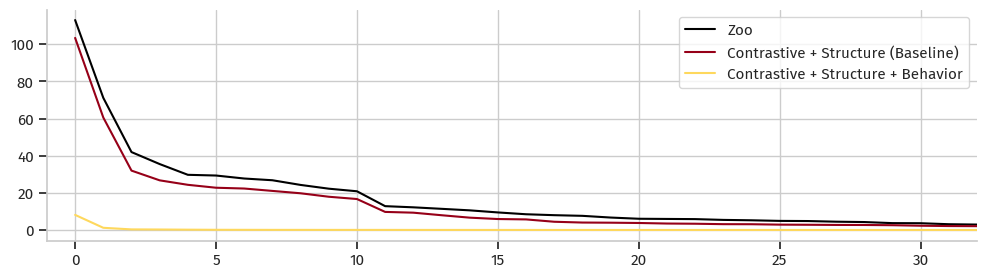

In [33]:
_, ax = plt.subplots(figsize=(12,3))

sns.lineplot(eigenvalues['Zoo'], ax=ax, color='black', label="Zoo")
sns.lineplot(eigenvalues['Contrastive + Structure (Baseline)'], ax=ax, color=COLOURS[0], label="Contrastive + Structure (Baseline)")
sns.lineplot(eigenvalues['Contrastive + Structure + Behavior'], ax=ax, color=COLOURS[1], label="Contrastive + Structure + Behavior")

ax.set(xlim=(-1, 32))

plt.legend()
plt.show()

In [34]:
df_eigen = pd.DataFrame(columns=['Hyper-representation model', 'Eigenvector index', 'Eigenvector similarity'])

for evdx in tqdm(range(eigenvectors['Zoo'].shape[1]), total=eigenvectors['Zoo'].shape[1]):
    for hr_idx, hr_label in idx_dict.items():
        df_eigen.loc[len(df_eigen)] = (
            hr_label,
            evdx,
            np.dot(eigenvectors['Zoo'][:,evdx], eigenvectors[hr_label][:,evdx])
        )
        
df_eigen.head()

  0%|          | 0/10853 [00:00<?, ?it/s]

,Hyper-representation model,Eigenvector index,Eigenvector similarity
0,Contrastive + Structure (Baseline),0,-0.987792
1,Behavior,0,0.004673
2,Contrastive + Behavior,0,0.053101
3,Structure + Behavior,0,0.119724
4,Contrastive + Structure + Behavior,0,0.131897


In [51]:
df_eigen[(np.abs(df_eigen['Eigenvector similarity']) >= 0.10) & (df_eigen['Hyper-representation model'] == 'Contrastive + Structure (Baseline)')]

,Hyper-representation model,Eigenvector index,Eigenvector similarity
0,Contrastive + Structure (Baseline),0,-0.987792
5,Contrastive + Structure (Baseline),1,-0.971372
10,Contrastive + Structure (Baseline),2,-0.947113
15,Contrastive + Structure (Baseline),3,-0.950645
20,Contrastive + Structure (Baseline),4,-0.584398
...,...,...,...
54195,Contrastive + Structure (Baseline),10839,0.127499
54205,Contrastive + Structure (Baseline),10841,-0.120667
54220,Contrastive + Structure (Baseline),10844,0.140118
54225,Contrastive + Structure (Baseline),10845,-0.172831


<Axes: ylabel='Eigenvector similarity'>

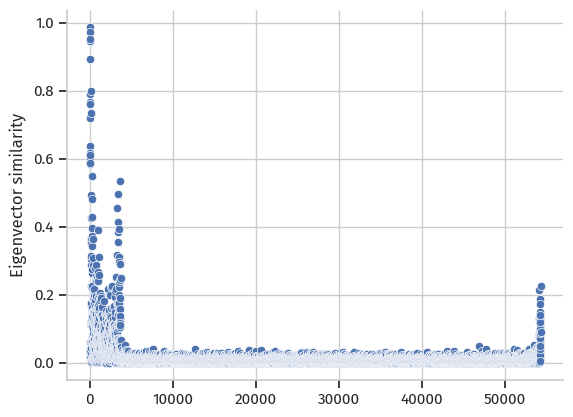

In [54]:
sns.scatterplot(np.abs(df_eigen[df_eigen['Hyper-representation model'] == 'Contrastive + Structure (Baseline)']['Eigenvector similarity']))

In [36]:
df_eigen[(np.abs(df_eigen['Eigenvector similarity']) > 0.20) & (df_eigen['Hyper-representation model'] == 'Contrastive + Behavior')]

,Hyper-representation model,Eigenvector index,Eigenvector similarity
3597,Contrastive + Behavior,719,0.267701
54152,Contrastive + Behavior,10830,-0.202145
54247,Contrastive + Behavior,10849,0.229586
54257,Contrastive + Behavior,10851,-0.340439
54262,Contrastive + Behavior,10852,-0.371254


In [37]:
df_eigen[(np.abs(df_eigen['Eigenvector similarity']) > 0.20) & (df_eigen['Hyper-representation model'] == 'Contrastive + Structure + Behavior')]

,Hyper-representation model,Eigenvector index,Eigenvector similarity
3599,Contrastive + Structure + Behavior,719,0.252288
3604,Contrastive + Structure + Behavior,720,0.257537
3609,Contrastive + Structure + Behavior,721,-0.231423
3649,Contrastive + Structure + Behavior,729,0.204999
54184,Contrastive + Structure + Behavior,10836,-0.225749
54259,Contrastive + Structure + Behavior,10851,0.328016
54264,Contrastive + Structure + Behavior,10852,0.362366


In [38]:
total_variance = np.sum(eigenvalues['Zoo'])
explained_variance = eigenvalues['Zoo'] / total_variance
cumulative_variance = np.cumsum(explained_variance)
k_top_half = np.searchsorted(cumulative_variance, 0.20) + 1
k_top = np.searchsorted(cumulative_variance, 0.40) + 1
print(f"Taking the top {k_top} eigenvalues")
df_eigen[df_eigen['Eigenvector index'] < k_top].groupby('Hyper-representation model').agg(lambda x: np.mean(np.abs(x)))

Taking the top 6 eigenvalues


,Eigenvector index,Eigenvector similarity
Hyper-representation model,,
Behavior,2.5,0.005098
Contrastive + Behavior,2.5,0.011805
Contrastive + Structure (Baseline),2.5,0.846467
Contrastive + Structure + Behavior,2.5,0.024166
Structure + Behavior,2.5,0.024439


In [39]:
explained_variance = explained_variance[::-1]
cumulative_variance = np.cumsum(explained_variance)
k_bot_half = np.searchsorted(cumulative_variance, 0.20) + 1
k_bot = np.searchsorted(cumulative_variance, 0.40) + 1
print(f"Taking the bottom {k_bot} eigenvalues")
k_max = df_eigen['Eigenvector index'].max().item()

df_eigen[df_eigen['Eigenvector index'] > k_max - k_bot].groupby('Hyper-representation model').agg(lambda x: np.mean(np.abs(x)))

Taking the bottom 10842 eigenvalues


,Eigenvector index,Eigenvector similarity
Hyper-representation model,,
Behavior,5431.5,0.008273
Contrastive + Behavior,5431.5,0.008108
Contrastive + Structure (Baseline),5431.5,0.014344
Contrastive + Structure + Behavior,5431.5,0.008154
Structure + Behavior,5431.5,0.008352


### Projection

In [40]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x)*np.linalg.norm(y))

In [49]:
top_eig = eigenvectors['Zoo'][:, :k_top]
bot_eig = eigenvectors['Zoo'][:, -k_bot:]
hyb_eig = np.hstack([eigenvectors['Zoo'][:, :k_top_half], eigenvectors['Zoo'][:, -k_bot_half:]])

top_recon = dict()
bot_recon = dict()
hyb_recon = dict()

for k, X in models.items():
    top_recon[k] = np.dot(np.dot(X, top_eig), top_eig.T)
    bot_recon[k] = np.dot(np.dot(X, bot_eig), bot_eig.T)
    hyb_recon[k] = np.dot(np.dot(X, hyb_eig), hyb_eig.T)
    
df_recon_comp = pd.DataFrame(columns=['Hyper-representation model', 'Eigenvectors', 'L2 distance'])

hr_label = 'Contrastive + Structure (Baseline)'
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Top',
    np.linalg.norm(top_recon['Zoo'] - top_recon[hr_label])
)
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Bottom',
    np.linalg.norm(bot_recon['Zoo'] - bot_recon[hr_label])
)
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Hybrid',
    np.linalg.norm(hyb_recon['Zoo'] - hyb_recon[hr_label])
)

hr_label = 'Contrastive + Behavior'
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Top',
    np.linalg.norm(top_recon['Zoo'] - top_recon[hr_label])
)
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Bottom',
    np.linalg.norm(bot_recon['Zoo'] - bot_recon[hr_label])
)
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Hybrid',
    np.linalg.norm(hyb_recon['Zoo'] - hyb_recon[hr_label])
)

hr_label = 'Contrastive + Structure + Behavior'
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Top',
    np.linalg.norm(top_recon['Zoo'] - top_recon[hr_label])
)
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Bottom',
    np.linalg.norm(bot_recon['Zoo'] - bot_recon[hr_label])
)
df_recon_comp.loc[len(df_recon_comp)] = (
    hr_label,
    'Hybrid',
    np.linalg.norm(hyb_recon['Zoo'] - hyb_recon[hr_label])
)

df_recon_comp

,Hyper-representation model,Eigenvectors,L2 distance
0,Contrastive + Structure (Baseline),Top,66.266851
1,Contrastive + Structure (Baseline),Bottom,300.211710
2,Contrastive + Structure (Baseline),Hybrid,276.861619
3,Contrastive + Behavior,Top,619.283764
4,Contrastive + Behavior,Bottom,1024.149221
5,Contrastive + Behavior,Hybrid,1090.062950
6,Contrastive + Structure + Behavior,Top,495.345507
7,Contrastive + Structure + Behavior,Bottom,565.064921
8,Contrastive + Structure + Behavior,Hybrid,590.830604


### Relating eigenvectors

In [45]:
for idx in range(16):
    vector = eigenvectors['Contrastive + Structure (Baseline)'][:,idx]

    max_sim = 0.
    max_idx = -1

    for evdx in range(eigenvectors['Zoo'].shape[1]):
        sim = np.abs(np.dot(vector, eigenvectors['Zoo'][:,evdx]))
        if sim > max_sim:
            max_sim = sim
            max_idx = evdx

    print(f"{idx} => {max_idx}: {max_sim}")

0 => 0: 0.9877916510486544
1 => 1: 0.971372461256343
2 => 2: 0.9471133226397445
3 => 3: 0.9506449453692756
4 => 5: 0.7168224223872733
5 => 4: 0.6549656053765329
6 => 6: 0.7189537886529126
7 => 7: 0.5904206546668292
8 => 8: 0.7914021961023551
9 => 10: 0.7272676102060297
10 => 9: 0.7269535088914421
11 => 11: 0.7658526424280858
12 => 12: 0.7593790375736664
13 => 13: 0.8933364067481347
14 => 15: 0.9089132716410551
15 => 17: 0.8451952616302925


In [46]:
for idx in range(16):
    vector = eigenvectors['Behavior'][:,idx]

    max_sim = 0.
    max_idx = -1

    for evdx in range(eigenvectors['Zoo'].shape[1]):
        sim = np.abs(np.dot(vector, eigenvectors['Zoo'][:,evdx]))
        if sim > max_sim:
            max_sim = sim
            max_idx = evdx

    print(f"{idx} => {max_idx}: {max_sim}")

0 => 258: 0.04359120721297293
1 => 5392: 0.03675149461379941
2 => 2611: 0.038466973517128474
3 => 1696: 0.04331183211643959
4 => 5812: 0.0415330024314882
5 => 5376: 0.034174741651466334
6 => 9851: 0.039018258721441816
7 => 5800: 0.04119141921725981
8 => 2834: 0.03826577419357542
9 => 4374: 0.03856279656965035
10 => 8975: 0.035019932670640665
11 => 584: 0.0363868231118439
12 => 7164: 0.0401373802713987
13 => 9107: 0.03998037654938976
14 => 8576: 0.03695292034136088
15 => 462: 0.04104532216203556


In [47]:
for idx in range(16):
    vector = eigenvectors['Contrastive + Behavior'][:,idx]

    max_sim = 0.
    max_idx = -1

    for evdx in range(eigenvectors['Zoo'].shape[1]):
        sim = np.abs(np.dot(vector, eigenvectors['Zoo'][:,evdx]))
        if sim > max_sim:
            max_sim = sim
            max_idx = evdx

    print(f"{idx} => {max_idx}: {max_sim}")

0 => 0: 0.053101337674603406
1 => 0: 0.051951956768626184
2 => 9557: 0.04593323065208752
3 => 4821: 0.0382387205183495
4 => 5958: 0.04179759274663081
5 => 1305: 0.039700293722361314
6 => 7847: 0.040161375672526346
7 => 1573: 0.03531878913370973
8 => 10: 0.042710599680676115
9 => 6999: 0.04175020507731284
10 => 6399: 0.038624808572264836
11 => 3360: 0.03945536884501316
12 => 734: 0.045285895430342386
13 => 8088: 0.03871552497217489
14 => 3224: 0.035342857582468405
15 => 9557: 0.07938316721574186


In [48]:
for idx in range(16):
    vector = eigenvectors['Structure + Behavior'][:,idx]

    max_sim = 0.
    max_idx = -1

    for evdx in range(eigenvectors['Zoo'].shape[1]):
        sim = np.abs(np.dot(vector, eigenvectors['Zoo'][:,evdx]))
        if sim > max_sim:
            max_sim = sim
            max_idx = evdx

    print(f"{idx} => {max_idx}: {max_sim}")

0 => 0: 0.11972371149030109
1 => 0: 0.11277115008955818
2 => 512: 0.043277172466643414
3 => 30: 0.054036768929378545
4 => 10: 0.10106935462075496
5 => 0: 0.056555674388185824
6 => 3: 0.06372599719639917
7 => 3: 0.06370676796612183
8 => 12: 0.04080553777591416
9 => 7: 0.07888902611562693
10 => 3: 0.05616380548962756
11 => 5: 0.05527962038934627
12 => 2: 0.03993461562691056
13 => 13: 0.08674505098945182
14 => 4: 0.07548905689450525
15 => 2: 0.05188604889426856
